In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import glob

In [81]:
# Read all CSVs and combine them into one dataframe 
file_path = "./data/*.csv"
csv_files = glob.glob(file_path)

dataframes = []
for file in csv_files:
    temp_df = pd.read_csv(file, dtype={'FRSHTT': str})
    dataframes.append(temp_df)

df = pd.concat(dataframes, ignore_index=True)

# Display the first row
df.iloc[0]

STATION              841599999
DATE                2020-03-13
LATITUDE                   NaN
LONGITUDE                  NaN
ELEVATION                  NaN
NAME                      XM21
TEMP                      82.7
TEMP_ATTRIBUTES              6
DEWP                      73.2
DEWP_ATTRIBUTES              6
SLP                     1010.9
SLP_ATTRIBUTES               6
STP                      999.9
STP_ATTRIBUTES               0
VISIB                    999.9
VISIB_ATTRIBUTES             0
WDSP                      14.5
WDSP_ATTRIBUTES              6
MXSPD                     17.1
GUST                      21.0
MAX                       83.3
MAX_ATTRIBUTES               *
MIN                       82.2
MIN_ATTRIBUTES               *
PRCP                       0.0
PRCP_ATTRIBUTES              I
SNDP                     999.9
FRSHTT                  000000
Name: 0, dtype: object

In [82]:
df.shape

(350047, 28)

In [83]:
df.describe(include='all').iloc[:,4:]

,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,SLP,SLP_ATTRIBUTES,STP,STP_ATTRIBUTES,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
count,350045.000000,350047,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,...,350047.000000,350047.000000,350047.000000,350047,350047.000000,350047,350047.000000,350047,350047.000000,350047
unique,NaN,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,NaN,2,NaN,10,NaN,28
top,NaN,"LYCKSELE, SW",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,,NaN,,NaN,G,NaN,000000
freq,NaN,732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,212292,NaN,210751,NaN,133306,NaN,203326
mean,156.069698,NaN,43.684919,22.493357,315.783026,21.867004,5064.571796,12.125995,746.693729,11.524041,...,96.165249,659.500554,58.407340,NaN,46.395579,NaN,16.612963,NaN,922.233138,NaN
std,249.354753,NaN,13.661411,4.045943,1642.715116,5.404211,4473.751572,11.512061,423.780130,11.608378,...,270.405041,464.681444,296.820562,NaN,301.395863,NaN,37.144275,NaN,266.187857,NaN
min,1.820000,NaN,-73.600000,4.000000,-76.800000,0.000000,946.100000,0.000000,0.000000,0.000000,...,0.200000,9.700000,-71.000000,NaN,-75.800000,NaN,0.000000,NaN,0.400000,NaN
25%,16.000000,NaN,35.600000,24.000000,29.900000,24.000000,1009.000000,0.000000,784.150000,0.000000,...,9.700000,29.900000,40.100000,NaN,30.200000,NaN,0.000000,NaN,999.900000,NaN
50%,65.530000,NaN,44.200000,24.000000,38.600000,24.000000,1025.100000,14.000000,998.600000,7.000000,...,14.000000,999.900000,49.300000,NaN,38.500000,NaN,0.000000,NaN,999.900000,NaN
75%,180.000000,NaN,53.500000,24.000000,47.400000,24.000000,9999.900000,24.000000,999.900000,24.000000,...,22.000000,999.900000,59.900000,NaN,46.800000,NaN,0.200000,NaN,999.900000,NaN


In [84]:
df = df.loc[:, ~df.columns.str.endswith('_ATTRIBUTES')]
df = df.drop(['STATION', 'NAME', 'DATE'], axis=1)
df.describe()

,LATITUDE,LONGITUDE,ELEVATION,TEMP,DEWP,SLP,STP,VISIB,WDSP,MXSPD,GUST,MAX,MIN,PRCP,SNDP
count,350045.000000,350045.000000,350045.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000,350047.000000
mean,60.924623,8.419490,156.069698,43.684919,315.783026,5064.571796,746.693729,389.401802,88.210568,96.165249,659.500554,58.407340,46.395579,16.612963,922.233138
std,5.613061,16.159811,249.354753,13.661411,1642.715116,4473.751572,423.780130,478.966571,268.006117,270.405041,464.681444,296.820562,301.395863,37.144275,266.187857
min,49.207947,-73.000000,1.820000,-73.600000,-76.800000,946.100000,0.000000,0.000000,0.000000,0.200000,9.700000,-71.000000,-75.800000,0.000000,0.400000
25%,56.929144,-0.850000,16.000000,35.600000,29.900000,1009.000000,784.150000,7.000000,5.100000,9.700000,29.900000,40.100000,30.200000,0.000000,999.900000
50%,60.716667,10.833333,65.530000,44.200000,38.600000,1025.100000,998.600000,24.300000,8.300000,14.000000,999.900000,49.300000,38.500000,0.000000,999.900000
75%,64.616667,19.950000,180.000000,53.500000,47.400000,9999.900000,999.900000,999.900000,14.200000,22.000000,999.900000,59.900000,46.800000,0.200000,999.900000
max,83.650000,31.500000,3207.000000,90.000000,9999.900000,9999.900000,999.900000,999.900000,999.900000,999.900000,999.900000,9999.900000,9999.900000,99.990000,999.900000


In [85]:
total_nulls = int(df.isnull().sum().sum())
f"There are {total_nulls} null values"

'There are 6 null values'

In [86]:
# Convert the label column to one-hot encoded format
labels = df['FRSHTT'].apply(lambda x: list(map(int, x)))
labels = np.array(labels.tolist())

# Drop the original label column from the DataFrame
df = df.drop(columns=['FRSHTT'])

# Features (X)
X = df.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [87]:
%% Time

# Create a list to store individual models
models = []

# Train a separate model for each label
for i in range(labels.shape[1]):
    print(f"Training model for label {i+1}/{labels.shape[1]}")
    
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train[:, i])
    dtest = xgb.DMatrix(X_test, label=y_test[:, i])
    
    # Set parameters for binary classification
    params = {
        'objective': 'binary:logistic',  # Specify the objective for binary classification
        'eval_metric': 'logloss'         # Evaluation metric
    }
    
    # Train the model
    num_rounds = 100
    model = xgb.train(params, dtrain, num_rounds)
    
    # Store the trained model
    models.append(model)

# Make predictions for each label
preds = np.zeros((X_test.shape[0], labels.shape[1]))

for i, model in enumerate(models):
    dtest = xgb.DMatrix(X_test)
    preds[:, i] = model.predict(dtest)

# Convert predictions to binary (0 or 1)
preds_binary = (preds > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, preds_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')

Training model for label 1/6
Training model for label 2/6
Training model for label 3/6
Training model for label 4/6
Training model for label 5/6
Training model for label 6/6


In [ ]:
label_names = [
    "Fog",
    "Rain or Drizzle",
    "Snow or Ice Pellets",
    "Hail",
    "Thunder",
    "Tornado/Funnel Cloud"
]

# Initialize lists to store evaluation metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Evaluate each model
for i, model in enumerate(models):
    dtest = xgb.DMatrix(X_test)
    preds = model.predict(dtest)
    
    # Convert predictions to binary
    preds_binary = (preds > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test[:, i], preds_binary)
    precision = precision_score(y_test[:, i], preds_binary)
    recall = recall_score(y_test[:, i], preds_binary)
    f1 = f1_score(y_test[:, i], preds_binary)
    
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test[:, i], preds)
    roc_auc = auc(fpr, tpr)
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

/home/h05/llee/.conda/envs/data_readiness/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h05/llee/.conda/envs/data_readiness/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h05/llee/.conda/envs/data_readiness/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

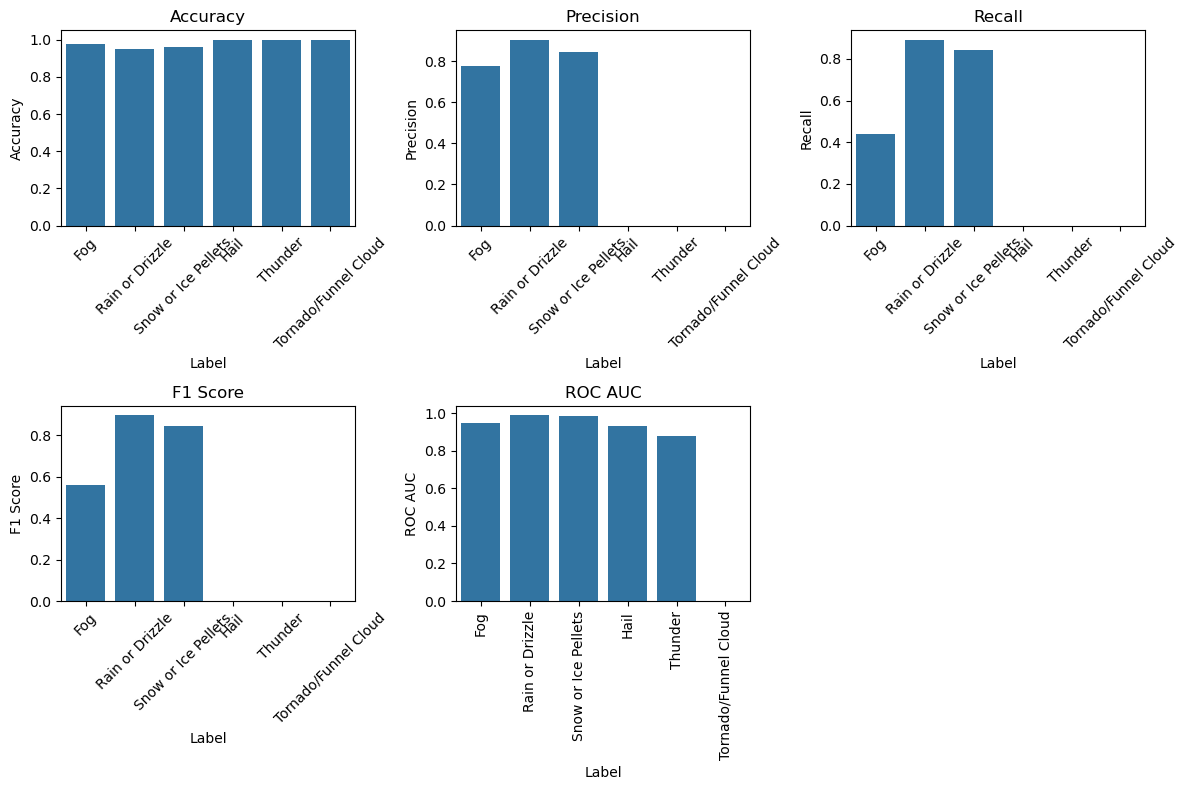

In [ ]:
# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Label': label_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'ROC AUC': roc_aucs
})

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 3, 1)
sns.barplot(x='Label', y='Accuracy', data=metrics_df)
plt.title('Accuracy')
plt.xticks(rotation=45)

# Plot Precision
plt.subplot(2, 3, 2)
sns.barplot(x='Label', y='Precision', data=metrics_df)
plt.title('Precision')
plt.xticks(rotation=45)

# Plot Recall
plt.subplot(2, 3, 3)
sns.barplot(x='Label', y='Recall', data=metrics_df)
plt.title('Recall')
plt.xticks(rotation=45)

# Plot F1 Score
plt.subplot(2, 3, 4)
sns.barplot(x='Label', y='F1 Score', data=metrics_df)
plt.title('F1 Score')
plt.xticks(rotation=45)

# Plot ROC AUC
plt.subplot(2, 3, 5)
sns.barplot(x='Label', y='ROC AUC', data=metrics_df)
plt.title('ROC AUC')
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

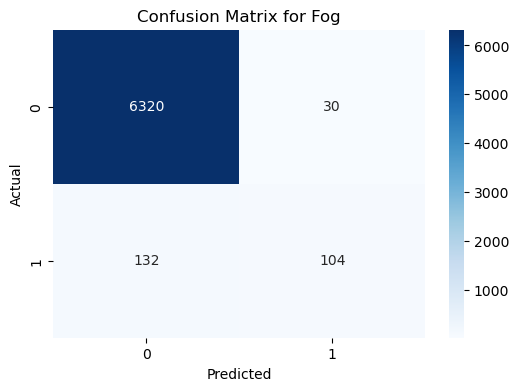

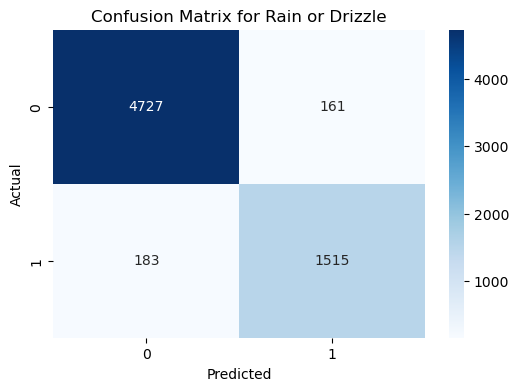

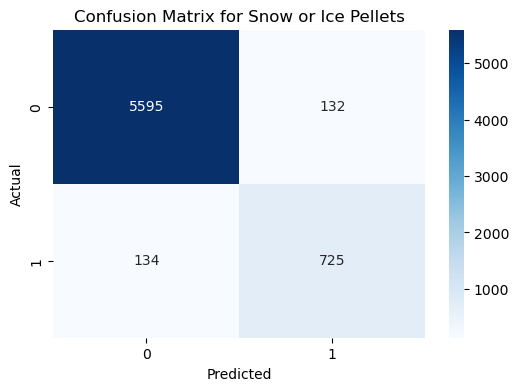

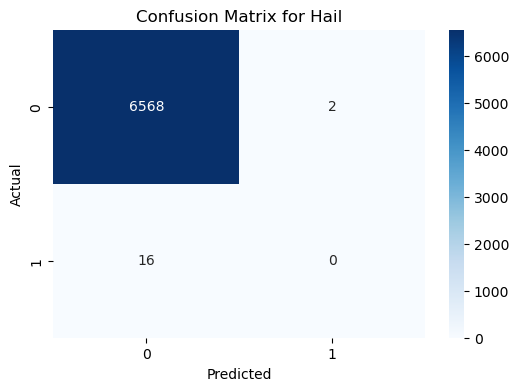

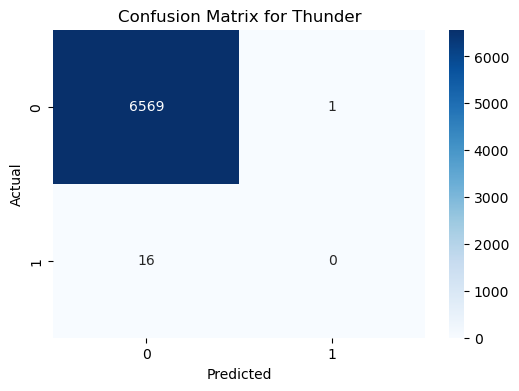

/home/h05/llee/.conda/envs/data_readiness/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


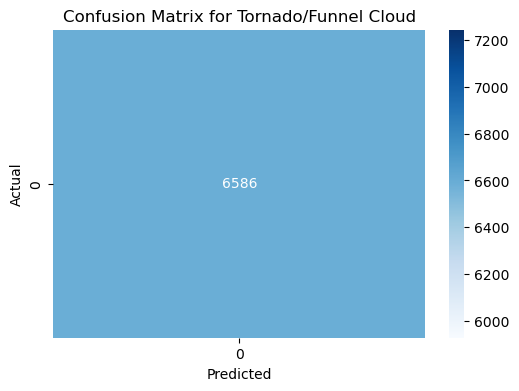

In [ ]:
# Plot confusion matrix for each label
for i, model in enumerate(models):
    dtest = xgb.DMatrix(X_test)
    preds = model.predict(dtest)
    
    # Convert predictions to binary
    preds_binary = (preds > 0.5).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test[:, i], preds_binary)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label_names[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

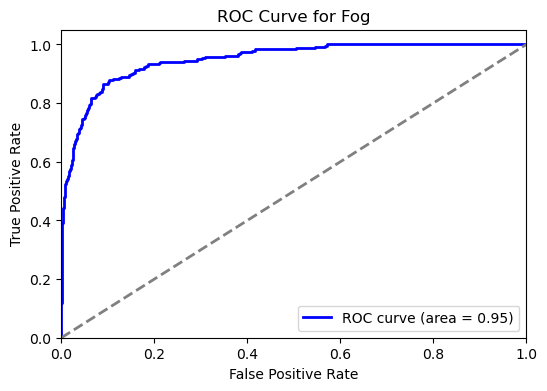

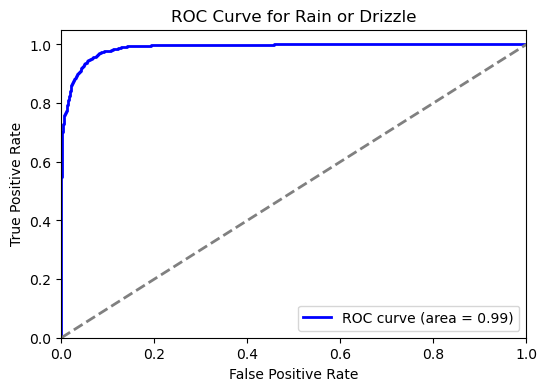

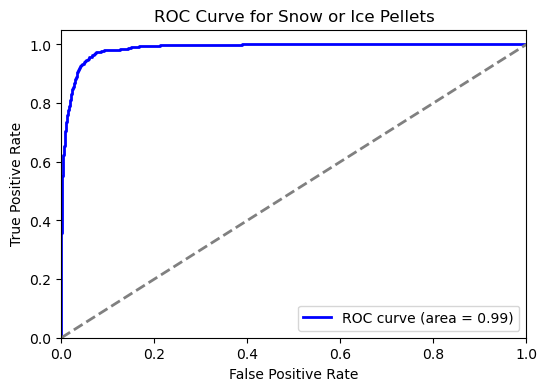

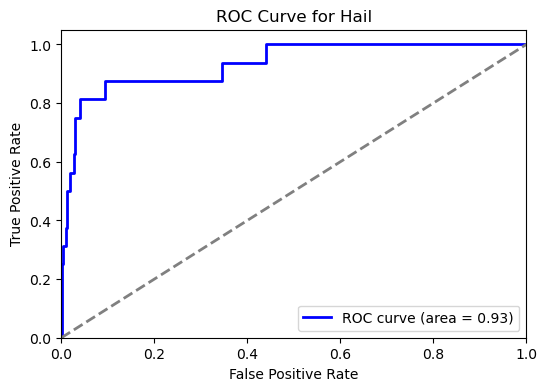

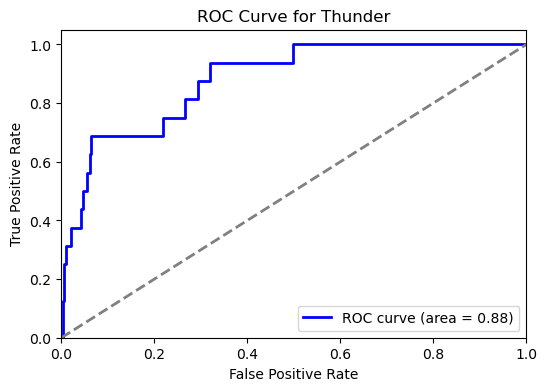

/home/h05/llee/.conda/envs/data_readiness/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


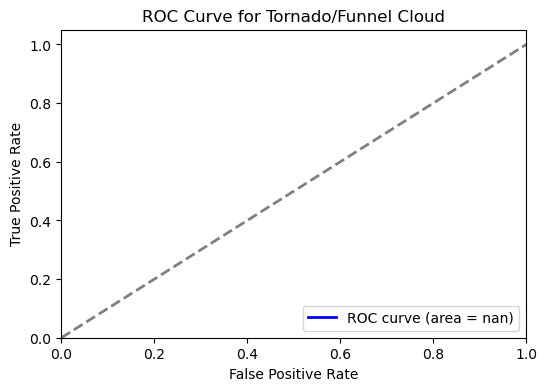

In [ ]:
# Plot ROC curve for each label
for i, model in enumerate(models):
    dtest = xgb.DMatrix(X_test)
    preds = model.predict(dtest)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test[:, i], preds)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {label_names[i]}')
    plt.legend(loc="lower right")
    plt.show()

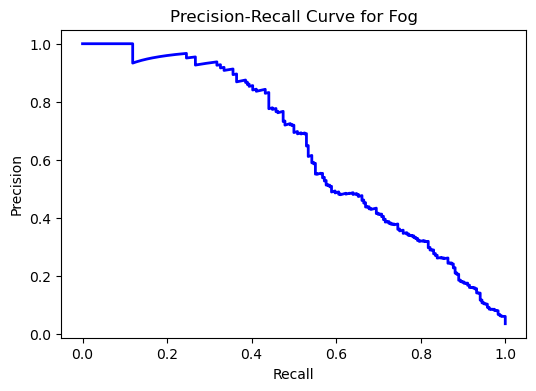

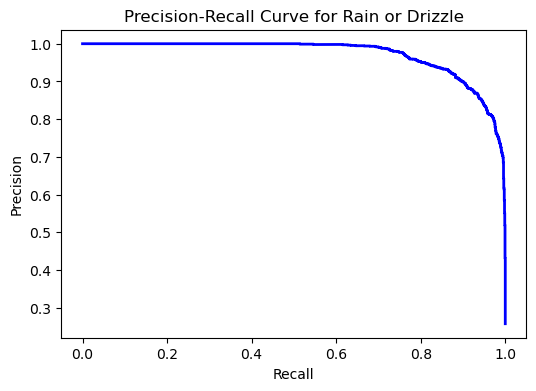

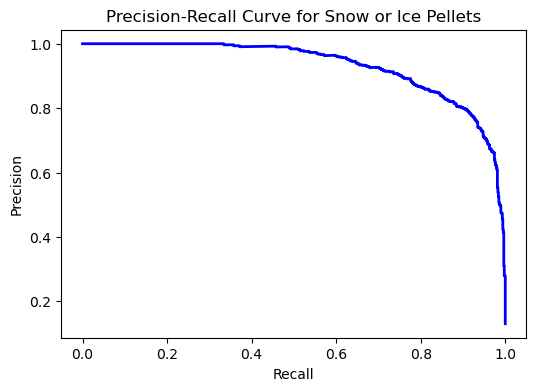

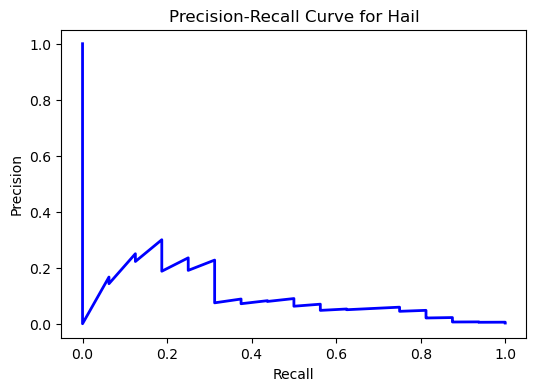

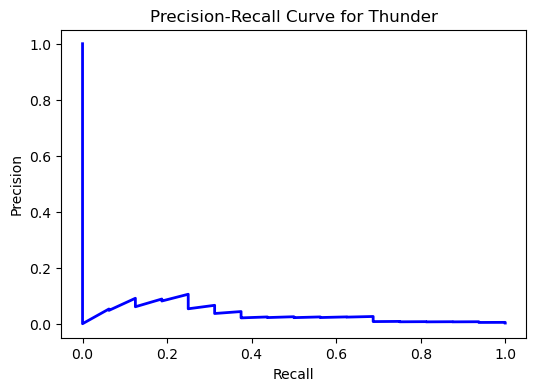

/home/h05/llee/.conda/envs/data_readiness/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


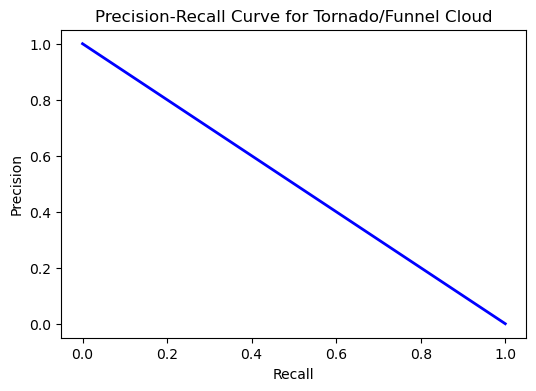

In [ ]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall curve for each label
for i, model in enumerate(models):
    dtest = xgb.DMatrix(X_test)
    preds = model.predict(dtest)
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test[:, i], preds)
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {label_names[i]}')
    plt.show()